In [1]:
!nvidia-smi

Tue Mar  2 10:03:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 706kB 7.8MB/s 


In [3]:
!wget http://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip

--2021-03-02 10:03:16--  http://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip [following]
--2021-03-02 10:03:17--  https://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333074849 (318M) [application/zip]
Saving to: ‘camera_scene_detection_train.zip’

camera_scene_detect 100%[===================>] 317.64M  20.4MB/s    in 17s     

2021-03-02 10:03:35 (18.7 MB/s) - ‘camera_scene_detection_train.zip’ saved [333074849/333074849]



In [4]:
!unzip camera_scene_detection_train.zip

Streaming output truncated to the last 5000 lines.
  inflating: training/23_Fireworks/60.jpg  
  inflating: training/23_Fireworks/61.jpg  
  inflating: training/23_Fireworks/62.jpg  
  inflating: training/23_Fireworks/63.jpg  
  inflating: training/23_Fireworks/64.jpg  
  inflating: training/23_Fireworks/65.jpg  
  inflating: training/23_Fireworks/66.jpg  
  inflating: training/23_Fireworks/67.jpg  
  inflating: training/23_Fireworks/68.jpg  
  inflating: training/23_Fireworks/69.jpg  
  inflating: training/23_Fireworks/7.jpg  
  inflating: training/23_Fireworks/70.jpg  
  inflating: training/23_Fireworks/71.jpg  
  inflating: training/23_Fireworks/72.jpg  
  inflating: training/23_Fireworks/73.jpg  
  inflating: training/23_Fireworks/74.jpg  
  inflating: training/23_Fireworks/75.jpg  
  inflating: training/23_Fireworks/76.jpg  
  inflating: training/23_Fireworks/77.jpg  
  inflating: training/23_Fireworks/78.jpg  
  inflating: training/23_Fireworks/79.jpg  
  inflating: training/23_F

In [5]:
from imutils import paths
from pprint import pprint
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_addons as tfa
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import time

In [6]:
# Fix the random seeds
np.random.seed(666)
tf.random.set_seed(666)

In [7]:
image_paths = list(paths.list_images("training"))
np.random.shuffle(image_paths)
image_paths[:5]

['training/15_Sunset_Sunrise/255.jpg',
 'training/28_Text_Documents/262.jpg',
 'training/20_Flower/39.jpg',
 'training/3_Kids/214.jpg',
 'training/24_Candle_light/34.jpg']

In [8]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count)

Counter({'4_Dog': 502,
         '14_Architecture': 463,
         '15_Sunset_Sunrise': 420,
         '7_Food': 400,
         '5_Cat': 373,
         '6_Macro': 357,
         '9_Mountain': 352,
         '11_Snow': 344,
         '12_Landscape': 335,
         '8_Beach': 334,
         '10_Waterfall': 326,
         '2_Group_portrait': 324,
         '16_Blue_Sky': 322,
         '22_Stage_concert': 322,
         '1_Portrait': 319,
         '23_Fireworks': 317,
         '21_Night_shot': 316,
         '24_Candle_light': 313,
         '30_Computer_Screens': 308,
         '17_Cloudy_Sky': 307,
         '28_Text_Documents': 306,
         '26_Indoor': 298,
         '13_Underwater': 296,
         '19_Autumn_leaves': 295,
         '18_Greenery': 294,
         '3_Kids': 281,
         '27_Backlight': 280,
         '20_Flower': 279,
         '25_Neon_lights': 269,
         '29_QR_images': 245})


In [9]:
IMAGE_SIZE = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 224
  CROP_TO = 224

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [10]:
TRAIN_SPLIT = 0.9
IMG_SIZE = 224
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
EPOCHS = 150

In [11]:
i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

8907 990


In [12]:
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
validation_labels_le = le.transform(validation_labels)
print(train_labels_le[:5])

[ 5 19 11 23 15]


In [13]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 64
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 36
  
@tf.function
def load_images(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) /255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return (image, label)

In [14]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)
val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))
val_ds = (
    val_ds
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

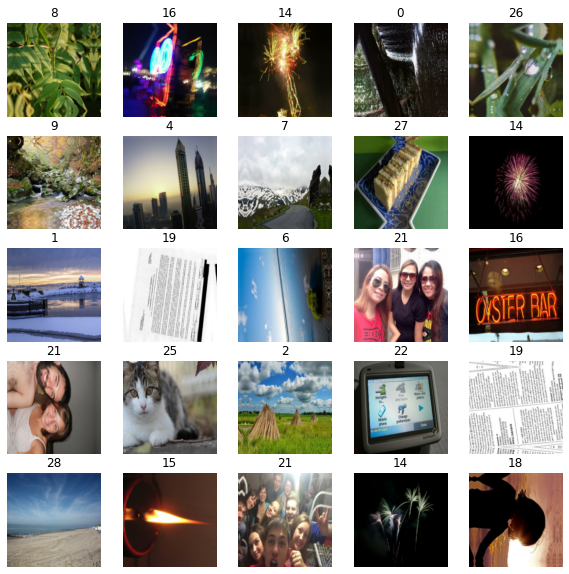

In [16]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis('off')

In [17]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url, trainable=True)

In [18]:
EPOCHS

150

In [19]:
# class MyBiTModel(tf.keras.Model):
#   def __init__(self, module):
#     super().__init__()
#     self.dense1 = tf.keras.layers.Dense(128)
#     self.normalize = Lambda(lambda a: tf.math.l2_normalize(a, axis=1))
#     self.bit_model = module
  
#   def call(self, images):
#     bit_embedding = self.bit_model(images)
#     dense1_representations = self.dense1(bit_embedding)
#     return self.normalize(dense1_representations)

class MyBiTModel(tf.keras.Model):

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = GlobalAveragePooling2D()
    self.head = Dense(512, activation="relu")
    self.head = Dropout(0.5)
    self.head = Dense(num_classes, activation="softmax", dtype="float32")
    self.bit_model = module

  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

In [20]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [21]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, verbose=2, mode="auto",
    restore_best_weights=True
)

In [22]:
def plot_training(H, embedding_dim):
    with plt.xkcd():
        plt.plot(H.history["loss"], label="train_loss")
        plt.plot(H.history["val_loss"], label="val_loss")
        plt.title("Embedding dim: {}".format(embedding_dim))
        plt.legend(loc="lower left")
        plt.show()

In [ ]:
model = MyBiTModel(num_classes=30,module=module)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

start = time.time()
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    # steps_per_epoch=30,
    epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  
    validation_data=val_ds,
    callbacks=[es]  
                                   
)
end = time.time()-start
print("Model takes {} seconds to train".format(end))

plot_training(history, 64)

Epoch 1/111
140/140 [==============================] - 174s 1s/step - loss: 1.4981 - accuracy: 0.6517 - val_loss: 0.2670 - val_accuracy: 0.9303
Epoch 2/111
140/140 [==============================] - 169s 1s/step - loss: 0.1720 - accuracy: 0.9586 - val_loss: 0.2658 - val_accuracy: 0.9313
Epoch 3/111
140/140 [==============================] - 169s 1s/step - loss: 0.1647 - accuracy: 0.9629 - val_loss: 0.2652 - val_accuracy: 0.9313
Epoch 4/111
140/140 [==============================] - 173s 1s/step - loss: 0.1665 - accuracy: 0.9586 - val_loss: 0.2645 - val_accuracy: 0.9313
Epoch 5/111
140/140 [==============================] - 171s 1s/step - loss: 0.1653 - accuracy: 0.9593 - val_loss: 0.2638 - val_accuracy: 0.9313
Epoch 6/111
140/140 [==============================] - 172s 1s/step - loss: 0.1640 - accuracy: 0.9618 - val_loss: 0.2630 - val_accuracy: 0.9313
Epoch 7/111
140/140 [==============================] - 173s 1s/step - loss: 0.1701 - accuracy: 0.9566 - val_loss: 0.2622 - val_accuracy:

In [ ]:
model.save('bit_image_scene')
model.save('bit_image_scene.h5')